In [259]:
import numpy as np, pandas as pd, seaborn as sns, time, matplotlib.pyplot as plt, copy
from numba import njit, prange
%matplotlib inline

In [260]:
dir_linux = !ls -a
dir_win = !dir /b
dir_all = list(dir_linux) + list(dir_win)
if 'kernel-metadata.json' in dir_all:
    src_local = True
    print('Local')
else:
    src_local = False
    print('Kaggle')

if src_local:
    data_folder = '../../../data/santa-workshop-tour-2019/'
else:
    data_folder = '../input/santa-2019-workshop-scheduling/'

Local


In [261]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../../data/santa-workshop-tour-2019/family_data.csv
../../../data/santa-workshop-tour-2019/sample_submission.csv


In [262]:
step_1 = True
step_2 = True
step_3 = True
step_4 = True
step_5 = False
step_99 = False

In [263]:
fpath = data_folder + 'family_data.csv'
df = pd.read_csv(fpath, index_col='family_id')

fpath = data_folder + 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [264]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
OPTIMAL_OCCUPANCY = 210
OPTIMAL_OCCUPANCY_MIN = 205
OPTIMAL_OCCUPANCY_MAX = 215

In [311]:
def get_day_counts(day):
    return family_day_assign[family_day_assign['choice_day']==day]['people'].sum()

In [312]:
family_cost_matrix = pd.DataFrame()
choice_list = [choice for choice in range(0,11)]
for n in df['n_people'].unique():
    penalties = [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    people_list = [n for p in choice_list]
    cost_dict = [{'people': n, 'choice': choice_list[x], 'penalty': penalties[x]} for x in choice_list]
    df_cost = pd.DataFrame(cost_dict, columns=['people', 'choice', 'penalty'])
    family_cost_matrix = pd.concat([family_cost_matrix, df_cost])
family_cost_matrix = family_cost_matrix.reset_index(drop=True)

In [313]:
def get_family_cost():
    day_counts = calc_day_counts()
    cost = family_day_assign.merge(family_cost_matrix
                                      , left_on=['people', 'choice_number']
                                      , right_on=['people', 'choice'])['penalty'].sum()
    return cost

In [314]:
def get_accounting_cost(count, diff):
    cost = max(0, (count-125.0) / 400.0 * count**(0.5 + diff / 50.0))
    return cost

In [315]:
# Calculate the accounting cost
# The first day (day 100) is treated special
def get_total_accounting_cost():
    day_counts = calc_day_counts()
    day_counts_dict = day_counts.to_dict()['people']
    
    today_count = day_counts_dict[100]
    if today_count >= MIN_OCCUPANCY and today_count <= MAX_OCCUPANCY:
        accounting_cost = (today_count-125.0) / 400.0 * today_count**(0.5)
    else:
        accounting_cost = 0
    
    today = 99
    yesterday = 100
    yesterday_count = day_counts_dict[yesterday]
    accounting_cost = 0
    for today in range(99,0,-1):
        yesterday = today + 1
        # today_count = day_counts.iat[day, 0]
        today_count = day_counts_dict[today]
        diff = abs(today_count - yesterday_count)
        if (today_count >= MIN_OCCUPANCY 
            and today_count <= MAX_OCCUPANCY 
            and yesterday_count <= MIN_OCCUPANCY 
            and yesterday_count <= MAX_OCCUPANCY):
            accounting_cost += max(0, get_accounting_cost(today_count, diff))
        yesterday_count = today_count
    return accounting_cost

In [316]:
def calc_day_counts():
    day_counts = pd.DataFrame([], columns=['day', 'people'])
    for day in range(1, 101):
        count = family_day_assign[family_day_assign['choice_day']==day]['people'].sum()
        count_row = pd.DataFrame([{'day': day
                               , 'people': count}])
        day_counts = day_counts.append(count_row, sort=False)
    day_counts = day_counts.set_index('day')
    return day_counts

In [317]:
def get_day_costs():
    day_counts = calc_day_counts()
    cost = 0
    for day in range(1, 101):
        count = day_counts.at[day, 'people']
        if count > MAX_OCCUPANCY:
            cost = 100000000
            break
        if count < MIN_OCCUPANCY:
            cost = 100000000
            break
    return cost

In [318]:
def get_total_costs():
    family_cost = get_family_cost()
    accounting_cost = get_total_accounting_cost()
    day_cost = get_day_costs()
    cost = family_cost + accounting_cost + day_cost
    return cost

<Figure size 432x288 with 0 Axes>

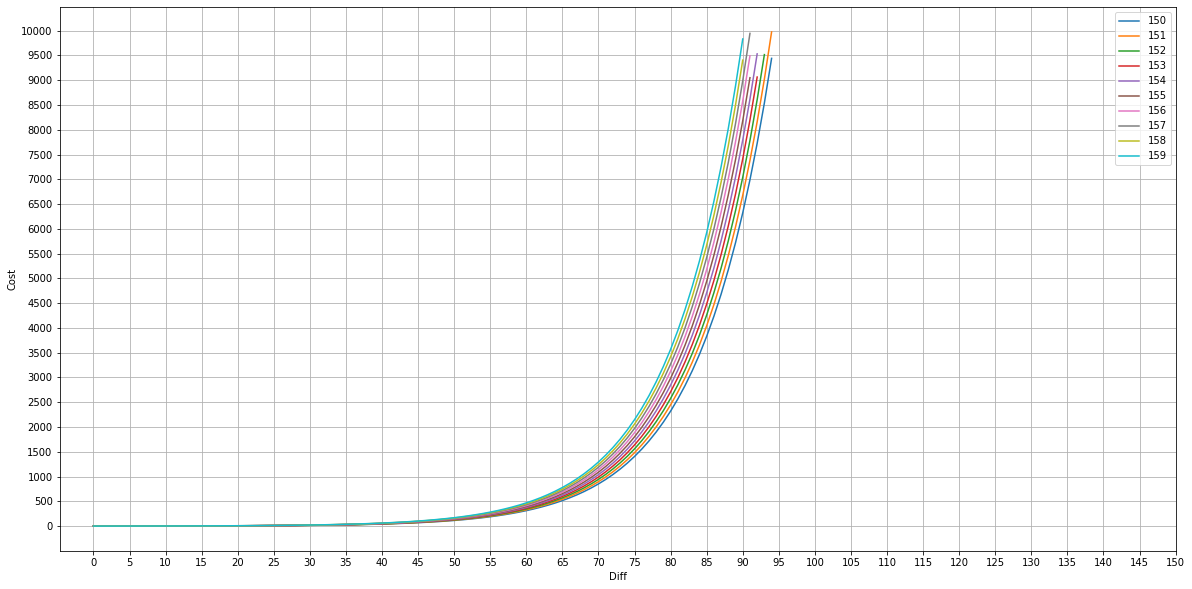

In [319]:
costs = []
counts = [c for c in range(150,301)]
for c in counts:
    for d in range(0, max(300-c, c-150)+1):
        cost = get_accounting_cost(c,d)
        cost_entry = {'count': c, 'diff': d, 'cost': cost}
        costs.append(cost_entry)

        
fig = plt.figure()
plt.figure(figsize=(20,10))
for count in range(150,160):
    diffs=[cost_row['diff'] for cost_row in costs if (cost_row['count']==count and cost_row['cost']<10000)]
    c=[cost_row['cost'] for cost_row in costs if (cost_row['count']==count and cost_row['cost']<10000)]
    ax = sns.lineplot(x=diffs, y=c)
    plt.legend(counts)
plt.xlabel('Diff')
plt.ylabel('Cost')
plt.xticks(range(0, 155, 5))
plt.yticks(range(0, 10500, 500))
plt.grid(axis='both')
plt.show()

In [320]:
choices = list(df.columns)
choice_numbers = []
for col in choices:
    if col[0:7] != 'choice_':
        choices.remove(col)
for choice in choices:
    choice_numbers.append(int(choice[7:]))

In [321]:
family_day_assign = pd.DataFrame([], columns=['family', 'choice_number', 'choice_day', 'people'])
t_elapsed = 0
print('Start')

Start


In [322]:
# Starting with choice 0, assign day to families if occupancy is within optimal_occupancy. iterate through choice_numbers
if step_1:
    t_start = time.perf_counter()
    for choice_number in choice_numbers:
        choice = 'choice_' + str(choice_number)
        for family in df.sort_values(by=['n_people'], ascending=False).index:
            if family not in list(family_day_assign['family']):
                assigned = False
                people = df.at[family, 'n_people']
                if not assigned:
                    choice_day = int(df.at[family, choice])
                    new_count = get_day_counts(choice_day) + people
                    if (new_count <= OPTIMAL_OCCUPANCY):
                        assign = pd.DataFrame([{'family': family
                                                , 'choice_number': choice_number
                                                , 'choice_day': choice_day
                                                , 'people': people}])
                        family_day_assign = family_day_assign.append(assign, sort=False)
                        assigned = True
    if 'family' in family_day_assign.columns:
        family_day_assign.set_index('family', inplace=True, drop=False)
    t_stop = time.perf_counter()
    t_elapsed += t_stop-t_start

In [323]:
# If no choice available, start assigning to meet optimal occupancy
if step_2:
    t_start = time.perf_counter()
    for family in df.sort_values(by=['n_people'], ascending=False).index:
        if family not in list(family_day_assign.index):
            assigned = False
            people = df.at[family, 'n_people']
            for day in range(100, 0, -1):
                if not assigned:
                    new_count = get_day_counts(day) + people
                    if new_count <= OPTIMAL_OCCUPANCY:
                        assign = pd.DataFrame([{'family': family
                                                , 'choice_number': 10
                                                , 'choice_day': day
                                                , 'people': people}])
                        family_day_assign = family_day_assign.append(assign, sort=False)
                        assigned = True
    if 'family' in family_day_assign.columns:
        family_day_assign.set_index('family', inplace=True, drop=False)
    t_stop = time.perf_counter()
    t_elapsed += t_stop-t_start

In [324]:
# Assign any small outliers
if step_3:
    t_start = time.perf_counter()
    for family in df.sort_values(by=['n_people'], ascending=False).index:
        if family not in list(family_day_assign.index):
            assigned = False
            people = df.at[family, 'n_people']
            for day in range(100, 0, -1):
                if not assigned:
                    new_count = get_day_counts(day) + people
                    OPTIMAL_OCCUPANCY_UPPER = OPTIMAL_OCCUPANCY + 4
                    if new_count <= OPTIMAL_OCCUPANCY_UPPER:
                        assign = pd.DataFrame([{'family': family
                                                , 'choice_number': 10
                                                , 'choice_day': day
                                                , 'people': people}])
                        family_day_assign = family_day_assign.append(assign, sort=False)
                        assigned = True
    if 'family' in family_day_assign.columns:
        family_day_assign.set_index('family', inplace=True, drop=False)
    t_stop = time.perf_counter()
    t_elapsed += t_stop-t_start

In [325]:
family_day_assign_base = copy.deepcopy(family_day_assign)

In [297]:
# family_day_assign = copy.deepcopy(family_day_assign_base)

In [168]:
# family_row = family_day_assign.at[1019, 'choice_number']
# family_row

In [169]:
# assigned_choice_number = int(family_row['choice_number'])
# assigned_choice_number 

In [326]:
family_day_assign.head()

,family,choice_number,choice_day,people
family,,,,
1840,1840,0,7,8
2680,2680,0,67,8
504,504,0,1,8
1822,1822,0,10,8
896,896,0,29,8


In [171]:
# family_day_assign.at[1019, 'choice_number'] = 4

In [329]:
# iterate through families descending by number of people, say 8
# save cost
# if choice_number is 10, if assigning to choice 9 will, reduce cost, while maintaining min and max counts, do it
# move on to next family
if step_4:
    t_start = time.perf_counter()
    better_choices = [a for a in range(10, 9, -1)]
    for choice in better_choices:
        new_choice = choice - 1
        new_choice_str = 'choice_' + str(new_choice)
        family_day_choice = family_day_assign.loc[family_day_assign['choice_number']==choice]
        for family in family_day_choice.sort_values(by=['people'], ascending=False).index:
            # initial cost
            orig_cost = get_day_costs()

            assigned_choice_number = choice
            assigned_choice_day = family_day_assign.at[family, 'choice_day']
            people = family_day_choice.at[family, 'people']
            
            if assigned_choice_number == choice:
                new_choice_day = df.at[family, new_choice_str]
                family_day_assign.at[family, 'choice_number'] = new_choice
                family_day_assign.at[family, 'choice_day'] = new_choice_day
                day_counts = calc_day_counts()
                
                # new cost
                new_cost = get_total_costs()
                
                if new_cost >= orig_cost:
                    family_day_assign.at[family, 'choice_number'] = assigned_choice_number
                    family_day_assign.at[family, 'choice_day'] = assigned_choice_day
    t_stop = time.perf_counter()
    t_elapsed += t_stop-t_start

KeyboardInterrupt: 

In [ ]:
day_counts = calc_day_counts()
unassigned_families = df.loc[[family for family in list(df.index) if family not in list(family_day_assign.index)]]

over_days = []
under_days = []
zero_days = []
families_assigned = family_day_assign.index

for day in range(1, 101):
    count = day_counts.at[day, 'people']
    if count > MAX_OCCUPANCY:
        over_days.append(day)
    if count < MIN_OCCUPANCY:
        under_days.append(day)
    if count == 0:
        zero_days.append(day)

In [ ]:
print('Over days: {}'.format(len(over_days)))
print('Under days: {}'.format(len(under_days)))
print('Zero days: {}'.format(len(zero_days)))
print('Families: {}'.format(len(families_assigned)))
print('{label:<30s}: {value:.2f}'.format(
            label='Elapsed time in minutes',
            value=t_elapsed/60))

In [257]:
family_cost = get_family_cost()
accounting_cost = get_total_accounting_cost()
day_cost = get_day_costs()
cost = family_cost + accounting_cost + day_cost
print('Family cost: {:,}'.format(family_cost))
print('Accounting cost: {:,}'.format(accounting_cost))
print('Day cost: {:,}'.format(day_cost))
print('Total cost: {:,}'.format(total_cost))

Family cost: 1,336,438
Accounting cost: 0.4880583734785301
Day cost: 100,000,000


In [214]:
# 1,336,438

<Figure size 432x288 with 0 Axes>

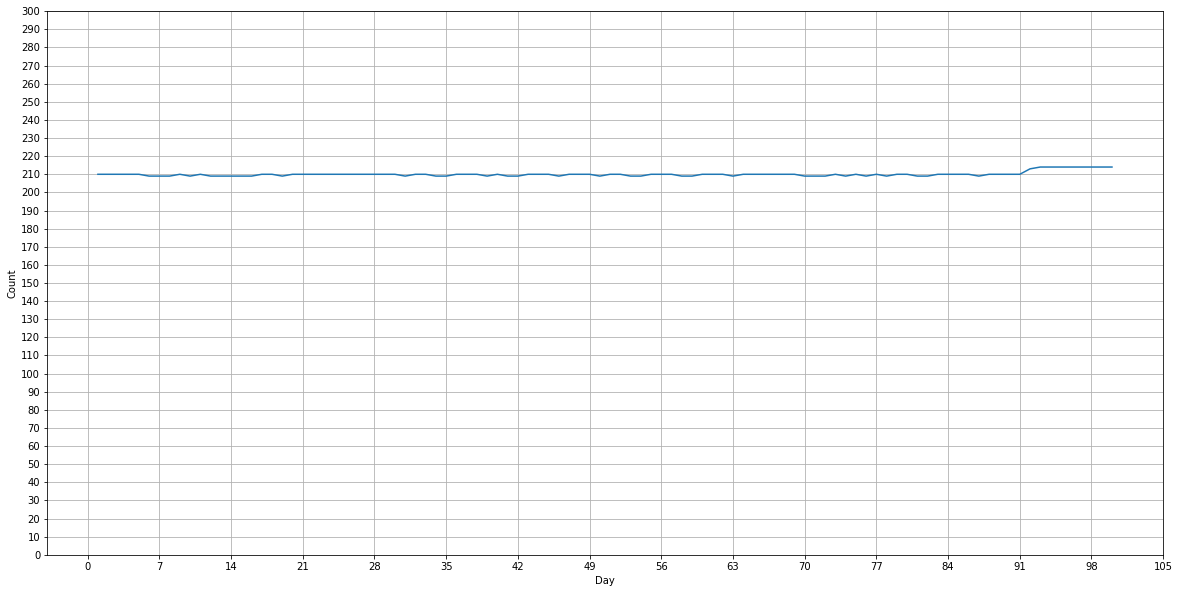

In [295]:
fig = plt.figure()
plt.figure(figsize=(20,10))
days = day_counts.index
counts = list(day_counts['people'])
ax = sns.lineplot(x=days, y=counts)
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(range(0, 106, 7))
plt.yticks(range(0, 305, 10))
plt.grid(axis='both')
plt.show()

In [180]:
unassigned_families.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,


<Figure size 432x288 with 0 Axes>

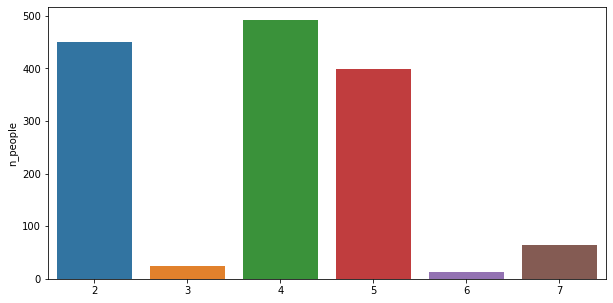

In [423]:
fig = plt.figure()
plt.figure(figsize=(10,5))
days = day_counts.index
counts = list(day_counts['people'])
# ax = sns.barplot(x=unassigned_families['n_people'].value_counts().index, y=unassigned_families['n_people'].value_counts())
ax = sns.barplot(x=unassigned_families['n_people'].unique(), y=unassigned_families['n_people'].value_counts())
# plt.xlabel('Day')
# plt.ylabel('Count')
# plt.xticks(range(0, 106, 7))
# plt.yticks(range(0, 305, 10))
# plt.grid(axis='both')
plt.show()

In [424]:
get_accounting_cost(215,5)

5.644761461437064